# Find Conspicuous Disks
Given an image with a background texture, and three overlaid textured disks, predict the centerpoint of the labeled “most conspicuous disk.” 

Currently based on the FCD5 dataset constructed with TexSyn.

In [1]:
# fcd_run_nickname = '_FCD5_a'
# fcd_run_nickname = '_delete_me'
fcd_run_nickname = '_FCD6_rc2'
default_dataset_directory = '/content/drive/My Drive/PredatorEye/fcd5_dataset/'
model_save_directory = '/content/drive/My Drive/PredatorEye/saved_models/'

# max_reads = 100
max_reads = 0

import gc
import PIL
import math
import time
import random
import numpy as np
from os import listdir
from os.path import join

import os.path

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
%tensorflow_version 2.x
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

# Import DiskFind utilities for PredatorEye.
import sys
sys.path.append('/content/drive/My Drive/PredatorEye/shared_code/')
import DiskFind as df

# df.set_global_random_seed(20220227)
df.set_global_random_seed(20220304)
# df.set_global_random_seed(20220317)

TensorFlow version: 2.8.0


# Reader for complex dataset

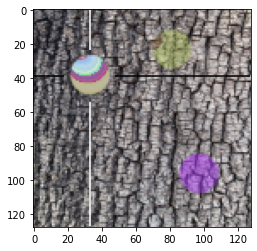

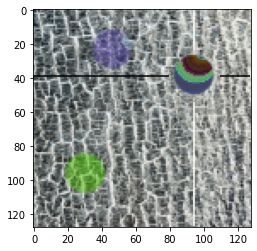

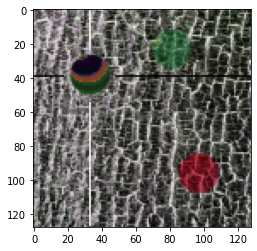

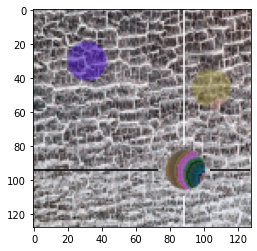

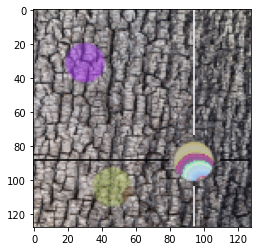

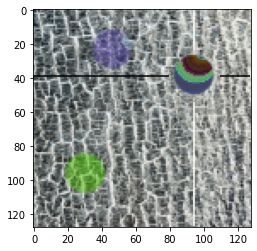

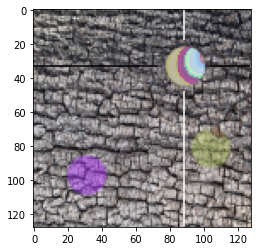

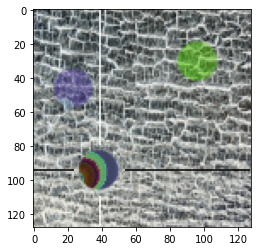

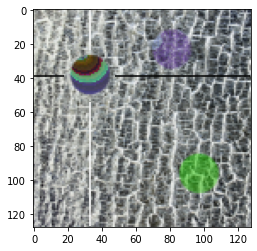

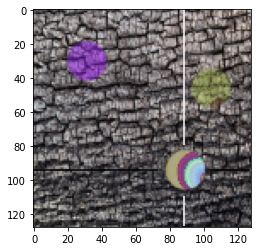

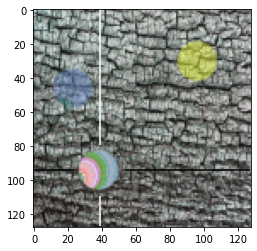

In [2]:
# Read entire dataset, images and xy position labels. Return two collections
def f3d_read_dataset(directory_pathname = default_dataset_directory):
    directory_contents = listdir(directory_pathname)
    if max_reads > 0:
        directory_contents = directory_contents[0:max_reads]
    images = []
    labels = []
    for filename in tqdm(directory_contents):
        image_pathname = os.path.join(directory_pathname, filename)
        (image, label) = f3d_make_training_example(image_pathname)
        images.append(image)
        labels.append(label)
    return (images, labels)

# Read image file at given pathname, pre-process for use in training model.
# def make_complex_example(image_pathname):
def f3d_make_training_example(image_pathname):
    # Read image file.
    pixels = df.read_image_file_as_pixel_tensor(image_pathname)
    # Check for expected format.
    if not df.check_pixel_tensor(pixels):
        msg = 'wrong image format, shape='+str(pixels.shape)+': '+image_pathname
        assert False, msg    
    # Parse disk center position from file name.
    filename = os.path.basename(image_pathname)
    center_position = df.fcd_normalized_xy(filename, pixels)
    return (pixels, center_position)

# Make modified copy of one training example (as a pixel tensor and xy label).
#     Half the time: invert brightness.
#     Half the time: mirror horizontally.
#     Rotate by 0, 90, 180, or 270 degrees.
def f3d_modify_training_example(image, label):
    def label_rot90(p): return (0.5 + (p[1] - 0.5), 0.5 - (p[0] - 0.5))
    def label_flip_h(p): return (0.5 - (p[0] - 0.5), 0.5 + (p[1] - 0.5))
    # Half the time: invert brighness of image.
    if random.random() > 0.5:
        image = 1 - image
    # Half the time: mirror horizontally
    if random.random() > 0.5:
        image = np.flip(image, axis=1)
        label = label_flip_h(label)
    # # 2/3 of the time: random hue rotation
    # if random.random() > 0.33:
    # 1/3 of the time: random hue rotation
    if random.random() > 0.66:
        tensor = tf.convert_to_tensor(image, dtype=tf.float32)
        # Use this, rather than tf.image.random_hue() for larger hue range.
        tensor = tf.image.adjust_hue(tensor, (random.random() - 0.5) * 2)
        image = tensor.numpy()
    # 1/3 of the time: tweak gamma.
    if random.random() > 0.66:
        tensor = tf.convert_to_tensor(image, dtype=tf.float32)
        gamma = 0.01 + random.random() * 2
        tensor = tf.image.adjust_gamma(tensor, gamma)
        image = tensor.numpy()
    # Rotate 0, 90, 180, or 270 degrees.
    n = random.randrange(0, 4)
    for i in range(n):
        image = np.rot90(image)
        label = label_rot90(label)
    return np.array(image, np.float32), np.array(label, np.float32)

def test_jig():
    df.reset_random_seeds()
    # pn = '/content/drive/My Drive/temp/crqtVaibvq_26_105.png'
    pn = '/content/drive/My Drive/temp/jQREPLQyuL_33_39.png'
    ti, tl = f3d_make_training_example(pn)
    df.draw_image(ti, tl)
    for i in range(10):
        mi, ml = f3d_modify_training_example(ti, tl)
        df.draw_image(mi, ml)
test_jig()

# Training batch generator.

In [3]:
# A "training batch generator" for F3D to do augmentation on the fly.
class Find3DisksGenerator(tf.keras.utils.Sequence):

    # Construct generator given arrays of base images and labels, and batch size
    # def __init__(self, base_images, base_labels, batch_size):
    def __init__(self, base_images, base_labels, augmentation, batch_size):
        self.base_images = base_images
        self.base_labels = base_labels
        # May be unneeded, but for simplicity let's assume both are powers of 2.
        assert is_power_of_2(augmentation)
        assert is_power_of_2(batch_size)
        self.augmentation = augmentation
        self.batch_size = batch_size

    # How many batches in this generator?
    def __len__(self):
        l = self.augmentation * len(self.base_images) / self.batch_size
        return math.ceil(l)

    # Returns images and labels for "index"-th batch.
    # TODO note this is surely not the most efficient/pythonic way to do this.
    def __getitem__(self, index):
        # Take the next "sub batch" chunk from base arrays.
        sb_size = int(self.batch_size / self.augmentation)
        start = index * sb_size
        end = (index + 1) * sb_size
        batch_images = self.base_images[start : end]
        batch_labels = self.base_labels[start : end]
        # Glue "augmentation" copies of each sub-batch array together.
        #    Probably could be done with numpy.repeat()?
        #    https://numpy.org/doc/stable/reference/generated/numpy.repeat.html
        repeated_images = (batch_images,) * self.augmentation
        repeated_labels = (batch_labels,) * self.augmentation
        batch_images = np.concatenate(repeated_images, axis=0)
        batch_labels = np.concatenate(repeated_labels, axis=0)
        # Now for all but last "sb_size" of each, make a modified augmentation.
        for i in range(self.batch_size - sb_size):
            image = batch_images[i]
            label = batch_labels[i]
            image, label = f3d_modify_training_example(image, label)
            batch_images[i] = image
            batch_labels[i] = label
        return np.array(batch_images), np.array(batch_labels)


# Read dataset and train model.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      1216      
                                                                 
 dropout (Dropout)           (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        12832     
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        51264     
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       2

  0%|          | 0/20000 [00:00<?, ?it/s]

Elapsed time: 506 seconds (8 minutes).
base_dataset_size: 20000
training_set_size: 16000
augmented_set_size: 256000
validation_set_size: 4000
61


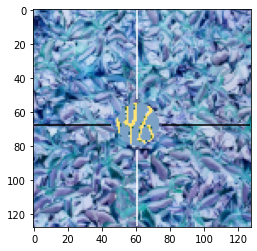

124


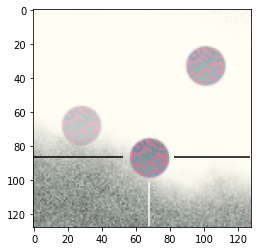

4


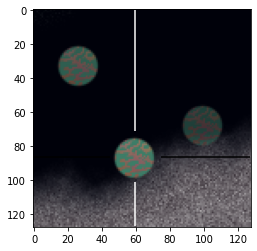

34


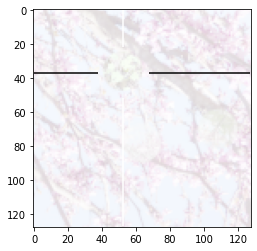

71


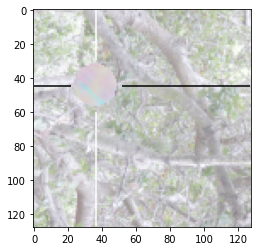

89


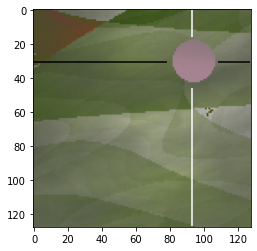

8


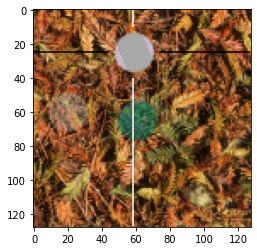

24


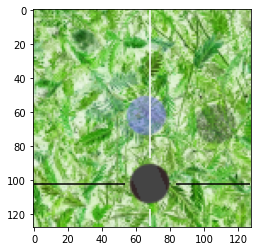

2


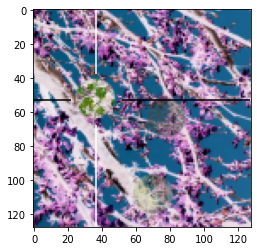

82


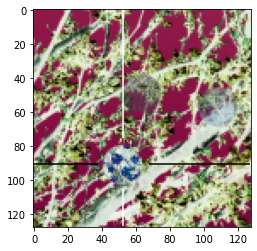

77


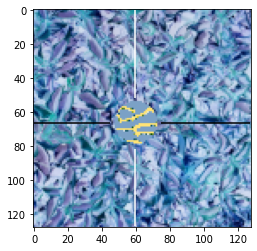

127


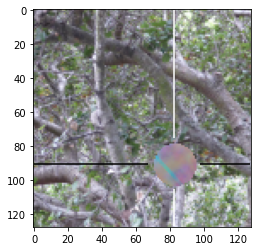

105


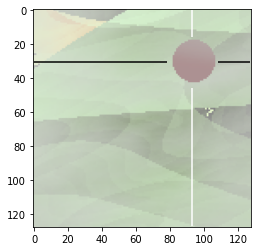

84


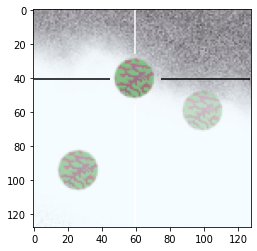

119


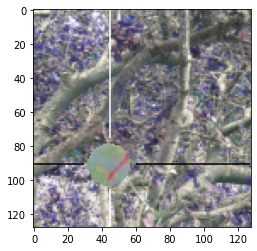

5


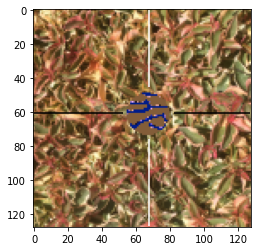

39


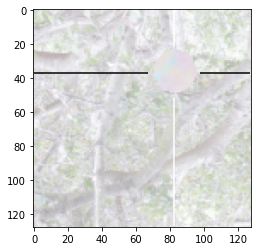

83


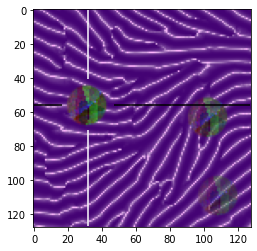

83


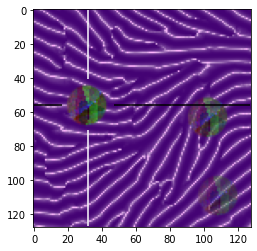

19


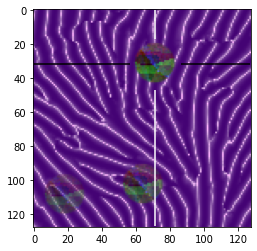

Epoch 1/100
2000/2000 [==============================] - 518s 253ms/step - loss: 0.0712 - accuracy: 0.4989 - in_disk: 0.0583 - val_loss: 0.0426 - val_accuracy: 0.4920 - val_in_disk: 0.0578
Epoch 2/100
2000/2000 [==============================] - 505s 253ms/step - loss: 0.0417 - accuracy: 0.5015 - in_disk: 0.0597 - val_loss: 0.0425 - val_accuracy: 0.4920 - val_in_disk: 0.0562
Epoch 3/100
2000/2000 [==============================] - 508s 254ms/step - loss: 0.0417 - accuracy: 0.5016 - in_disk: 0.0598 - val_loss: 0.0427 - val_accuracy: 0.4920 - val_in_disk: 0.0573
Epoch 4/100
2000/2000 [==============================] - 505s 252ms/step - loss: 0.0416 - accuracy: 0.5027 - in_disk: 0.0597 - val_loss: 0.0425 - val_accuracy: 0.4920 - val_in_disk: 0.0562
Epoch 5/100
 309/2000 [===>..........................] - ETA: 7:09 - loss: 0.0413 - accuracy: 0.4976 - in_disk: 0.0562

In [ ]:
# Read base dataset for F3D, reformat into images and labels, for train and test
def f3d_read_and_split_base_dataset():
    start_time = time.time()
    # Read base dataset, return lists of images and labels.
    base_images, base_labels = f3d_read_dataset()
    # Split both 80% / 20%.
    train_fraction = 0.8
    train_count = int(len(base_images) * train_fraction)
    train_images = base_images[: train_count]
    test_images = base_images[train_count : ]
    train_labels = base_labels[: train_count]
    test_labels = base_labels[train_count : ]
    # Ensure they are numpy arrays of type float32.
    train_images = np.array(train_images, dtype=np.float32)
    train_labels = np.array(train_labels, dtype=np.float32)
    test_images = np.array(test_images, dtype=np.float32)
    test_labels = np.array(test_labels, dtype=np.float32)
    # Log time to read.
    elapsed_seconds = int(time.time() - start_time)
    print('Elapsed time: ' + str(elapsed_seconds) + ' seconds (' +
          str(int(elapsed_seconds / 60)) +' minutes).')
    return train_images, train_labels, test_images, test_labels

# Train the given model with F3D dataset plus augmentation.
# Started as df.run_model(), then specialized for on-the-fly augmentation.
def f3d_train_augmented_model(model, epochs, batch_size, plot_title):
    # Read dataset.
    (train_images, train_labels,
     test_images, test_labels) = f3d_read_and_split_base_dataset()
    # Create generator for training batches.
    # changed 20220227
    # augmentation_factor = 8
    augmentation_factor = 16
    training_data_generator = Find3DisksGenerator(train_images,
                                                  train_labels,
                                                  augmentation_factor,
                                                  batch_size)    
    # Print some stats about dataset.
    training_set_size = train_images.shape[0]
    augmented_set_size = training_set_size * augmentation_factor
    validation_set_size = test_images.shape[0]
    print('base_dataset_size:', len(train_images) + len(test_images))
    print('training_set_size:', training_set_size)
    print('augmented_set_size:', augmented_set_size)
    print('validation_set_size:', validation_set_size)
    # Use generator to produce a training batch, visualize 20 of its examples.
    v_images, v_labels = training_data_generator[0]
    df.visualize_dataset(v_images, v_labels, count=20)
    # Train model from "training_data_generator"
    history = model.fit(training_data_generator,
                        validation_data = (test_images, test_labels),
                        epochs=epochs,
                        batch_size=batch_size)
    # Plot history of training metrics.
    print()
    df.plot_accuracy_and_loss(history, plot_title)
    # Visualize 20 examples from test set with both labels and predictions.
    df.visualize_dataset(images=test_images,
                         labels=test_labels,
                         model=model,
                         count=20)
    return history

def in_disk(y_true, y_pred):
    return df.in_disk(y_true, y_pred)

# Create a Keras deep learning model of appropriate architecture.
# (Revised 20220221 from df.make_disk_finder_model())
def make_f3d_model(X_train):
    cnn_act = 'relu'
    dense_act = 'relu'
    output_act = 'linear'
    cnn_filters = 32
    cnn_dropout = 0.2
    dense_dropout = 0.5  # ala Hinton (2012)
    input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3], )
    model = Sequential()
    # image shape 128x128, filters 16
    model.add(Conv2D(filters=16,
                     kernel_size=(5, 5), 
                     activation=cnn_act,
                     padding='same',
                     # kernel_constraint=MaxNorm(3),
                     input_shape=input_shape))
    model.add(Dropout(cnn_dropout))
    # image shape 128x128, filters 32
    model.add(Conv2D(filters=32,
                     kernel_size=(5, 5), 
                     activation=cnn_act,
                     padding='same',
                     # kernel_constraint=MaxNorm(3),
                     strides=(2, 2)))
    model.add(Dropout(cnn_dropout))
    # image shape 64x64, filters 64
    model.add(Conv2D(filters=64,
                     kernel_size=(5, 5), 
                     activation=cnn_act,
                     padding='same',
                     # kernel_constraint=MaxNorm(3),
                     strides=(2, 2)))
    model.add(Dropout(cnn_dropout))
    # image shape 32x32, filters 128
    model.add(Conv2D(filters=128,
                     kernel_size=(5, 5), 
                     activation=cnn_act,
                     padding='same',
                     # kernel_constraint=MaxNorm(3),
                     strides=(2, 2)))
    model.add(Dropout(cnn_dropout))
    # image shape 16x16

    ############################################################################
    # 20220316 add one more CNN layer? "FCD6"?

    model.add(Conv2D(filters=256,
                     kernel_size=(5, 5), 
                     activation=cnn_act,
                     padding='same',
                     # kernel_constraint=MaxNorm(3),
                     strides=(2, 2)))
    model.add(Dropout(cnn_dropout))
    # image shape 8x8 x 256

    # 20220317 add another CNN layer? "FCD6 RC2"?

    model.add(Conv2D(filters=512,
                     kernel_size=(5, 5), 
                     activation=cnn_act,
                     padding='same',
                     # kernel_constraint=MaxNorm(3),
                     strides=(2, 2)))
    model.add(Dropout(cnn_dropout))
    # image shape 4 x 4 x 512

    ############################################################################

    # Then flatten and use a large-ish dense layer with heavy dropout.
    model.add(Flatten())
    model.add(Dense(512, activation=dense_act))
    model.add(Dropout(dense_dropout))

    # Then funnel down to two output neurons for (x, y) of predicted center.
    model.add(Dense(128, activation=dense_act))
    model.add(Dense(32, activation=dense_act))
    model.add(Dense(8, activation=dense_act))
    model.add(Dense(2, activation=output_act))

    # Compile with mse loss, tracking accuracy and fraction-inside-disk.
    model.compile(loss='mse', optimizer='adam', metrics=["accuracy", in_disk])

    # Print description of model.
    model.summary()
    return model

# Entire F3D training run. Takes a couple of hours with GPU acceleration.
def f3d_run_augmented_model():
    df.reset_random_seeds()
    start_time = time.time()

    epochs = 100
    batch_size = 128
    model = make_f3d_model(np.zeros((1, 128, 128, 3)))
    fcd_model_timestamp = df.timestamp_string()

    # f3d_train_augmented_model(model, epochs, batch_size, 'test')
    f3d_train_augmented_model(model, epochs, batch_size, fcd_run_nickname)

    elapsed_seconds = int(time.time() - start_time)
    print('Elapsed time: ' + str(elapsed_seconds) + ' seconds (' +
        str(int(elapsed_seconds / 60)) +' minutes).')
    # Save trained model.
    model_save_path = (model_save_directory +
                    fcd_model_timestamp +
                    # '_F3D_augmented')
                    fcd_run_nickname)
    model.save(model_save_path)
    print('Saved trained model to', model_save_path)


# TODO 20220220 move?
# cf. https://stackoverflow.com/q/57025836/1991373
def is_power_of_2(n):
    i = 1
    while True:
        if i < n:
            i *= 2
        else:
            return i == n

# print('is_power_of_2(0) =', is_power_of_2(0))
# print('is_power_of_2(-1) =', is_power_of_2(-1))
# print('is_power_of_2(1) =', is_power_of_2(1))
# print('is_power_of_2(16) =', is_power_of_2(16))
# print('is_power_of_2(6) =', is_power_of_2(6))

# Run the whole thing.
f3d_run_augmented_model()